In [1]:
!pip install pymed

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import time
import random
from pymed import PubMed
from transformers import AutoTokenizer, AutoModel

%matplotlib inline

# Retrieve Abstracts

Referred to implementation [here](https://stackoverflow.com/questions/65148151/when-i-try-to-get-all-article-details-from-query-on-pubmed-to-pandas-dataframe-a).

In [138]:
df_mad = pd.read_csv('assets/df_mad.csv')

In [ ]:
pubmed = PubMed(tool="PubMedSearcher", email="jwh4001@med.cornell.edu")

In [ ]:
## ONLY RUN FIRST TIME
#abstract_list = []
#DRUGS = df_mad['DRUG_NAME']
#INDICATIONS = df_mad['study_name']
#for drug, tcga in zip(df_mad['DRUG_NAME'], df_mad['study_name']):
for drug, tcga in zip(DRUGS, INDICATIONS):
    
    search_term = drug + " " + tcga
    #start = time.time()
    results = pubmed.query(search_term, max_results=500)
    #end = time.time()
    articleList = []

    ## not to trigger 429 error
    ## 3 requests max per second
    #if end - start < 0.3:
    time.sleep(0.5)

    for article in results:
    ## convert PubMedArticle to dictionary
        articleDict = article.toDict()
        articleList.append(articleDict)

    ## list of dict records to hold article details fetched from PUBMED API
    for article in articleList:
        ## sometimes article['pubmed_id'] contains list separated with comma
        ## take first pubmedId in that list - thats article pubmedId
        pubmedId = article['pubmed_id'].partition('\n')[0]
        title = article['title']
        abstract = article['abstract']
        
        ## skip if abstract is None, '', or < 100 tokens
        if abstract is None or abstract == '' or len(abstract.split(' ')) < 100:
            continue

        ## skip if title None
        if article['abstract'] is None:
            continue

        ## skip None type before converting to UTF-8
        abstract = abstract.replace('\n', ' ').encode('ascii',errors='ignore').decode("utf-8")

        ## skip if drug name not in abstract
        if abstract.lower().find(drug.lower()) == -1:
            continue

        ## append article info to dictionary 
        abstract_list.append({u'drug': drug,
                              u'indication': tcga,
                              u'pubmed_id': pubmedId,
                              u'title': title,
                              #u'journal':article['journal'],
                              u'abstract': abstract})

In [ ]:
## if error pick up where the for loop left off
idx = df_mad.index[(df_mad['DRUG_NAME'] == drug) & (df_mad['study_name'] == tcga)]
n = len(df_mad['DRUG_NAME'])

DRUGS = df_mad['DRUG_NAME'][int(idx[0]):n]
INDICATIONS = df_mad['study_name'][int(idx[0]):n]

In [ ]:
## generate dataframe from list of dictionaries
df_articles = pd.DataFrame.from_dict(abstract_list)
# sum([len(i.split(' ')) > 512 for i in df_articles['abstract']])
df_articles['id'] = df_articles['drug'] + '_' + df_articles['indication']

In [140]:
## add ID to df_mad and column for whether or not abstract exists
df_mad['id'] = df_mad['DRUG_NAME'] + '_' + df_mad['study_name']
ids = list(np.unique(df_articles['id']))
df_mad['abstract_bool'] = list(map(lambda x: x in ids, df_mad['id']))

In [ ]:
## add sensitivity info to articles df
df_articles = pd.merge(df_articles, df_mad[['SENSITIVE', 'id']], on=['id'], how='inner')

In [ ]:
df_articles.to_csv('assets/articles.csv', index=False)

In [141]:
df_mad.to_csv('assets/df_mad.csv', index=False)

# Analyze Abstracts

In [5]:
df_mad = pd.read_csv('assets/df_mad.csv')

In [6]:
df_articles = pd.read_csv('assets/articles.csv')

In [10]:
df_articles['id'].value_counts().head(10)

Gemcitabine_Lung squamous cell carcinoma           426
Topotecan_Small cell lung cancer                   425
Docetaxel_Head and Neck squamous cell carcinoma    415
Docetaxel_Esophageal carcinoma                     414
Tamoxifen_Breast invasive carcinoma                413
Irinotecan_Small cell lung cancer                  409
Gemcitabine_Bladder Urothelial Carcinoma           406
Sorafenib_Kidney renal clear cell carcinoma        406
Gemcitabine_Lung adenocarcinoma                    403
Oxaliplatin_Stomach adenocarcinoma                 403
Name: id, dtype: int64

In [135]:
df_articles.shape

(59791, 7)

In [134]:
sum(df_articles['id'].value_counts() > 400)

10

In [117]:
df_mad.groupby(['abstract_bool', 'SENSITIVE']).size().reset_index(name='n')

,abstract_bool,SENSITIVE,n
0,False,False,2264
1,False,True,918
2,True,False,793
3,True,True,762


In [142]:
## distribution of sensitivity by abstract for stacked bar chart
df_count = df_mad.groupby(['abstract_bool', 'SENSITIVE']).size().reset_index(name='n')
vals = [('Total', False, df_mad['SENSITIVE'].value_counts()[0]), 
        ('Total', True, df_mad['SENSITIVE'].value_counts()[1])]
df_add = pd.DataFrame(vals, columns=df_count.columns)
df_count = df_count.append(df_add, ignore_index = True)
df_count = df_count.pivot(index='abstract_bool', columns='SENSITIVE', values='n')

In [143]:
df_count.div(df_count.sum(axis=1), axis=0)

SENSITIVE,False,True
abstract_bool,,
False,0.903834,0.096166
True,0.743408,0.256592
Total,0.851172,0.148828


In [121]:
df_count

SENSITIVE,False,True
abstract_bool,,
False,2264,918
True,793,762
Total,3057,1680


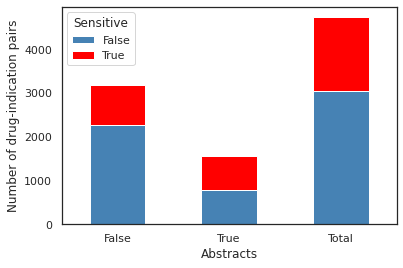

In [122]:
sns.set(style='white')
df_count.plot(kind='bar', stacked=True, color=['steelblue', 'red'])
plt.title('', fontsize=16);
plt.xlabel('Abstracts');
plt.ylabel('Number of drug-indication pairs');
plt.xticks(rotation=0);
plt.legend(title='Sensitive');

# totals = df_count.sum(axis=1)

# for n, x in enumerate([*cross_tab.index.values]):
#     for proportion in cross_tab_prop.loc[x]:
                
#         plt.text(x=n,
#                  y=proportion,
#                  s=f'{np.round(proportion * 100, 1)}%', 
#                  color="black",
#                  fontsize=12,
#                  fontweight="bold")

# plt.show()


# y_offset = 4
# for i, total in enumerate(totals):
#   axplt.text(totals.index[i], total + y_offset, round(total), ha='center',
#           weight='bold')

plt.savefig('images/stacked_bar.png')

In [146]:
sum(df_articles['SENSITIVE']) / len(df_articles['SENSITIVE'])

0.4060477329363951

In [147]:
n_true = sum(df_mad[(df_mad['abstract_bool'] == True)]['SENSITIVE'])
n_false = len(df_mad[(df_mad['abstract_bool'] == True)]['SENSITIVE']) - n_true

In [148]:
n_true + n_false

1555

In [149]:
list_random = [1] * n_true + [0] * n_false
# len(list_random)
# sum(df_mad['abstract_bool'] == True)

y = df_mad[(df_mad['abstract_bool'] == True)]['SENSITIVE']
n = len(y)

random.seed(123)
list_acc = []
list_precision = []
list_recall = []

for idx in range(1000):
    random.shuffle(list_random)
    list_acc.append(sum(list_random != y) / n)

    yhat_y1 = [list_random[i] for i in np.where(y == 1)[0]]
    yhat_y0 = [list_random[i] for i in np.where(y == 0)[0]]

    tp = sum(yhat_y1)
    fp = len(yhat_y1) - tp
    fn = sum(yhat_y0)
    # tn = len(yhat_y0) - fn

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    list_precision.append(precision)
    list_recall.append(recall)

In [151]:
list_f1 = [2 * (p * r) / (p + r) for p, r in zip(list_precision, list_recall)]

In [153]:
np.mean(list_f1)

0.2566040100250626

In [150]:
np.mean(list_acc)

0.3814983922829582

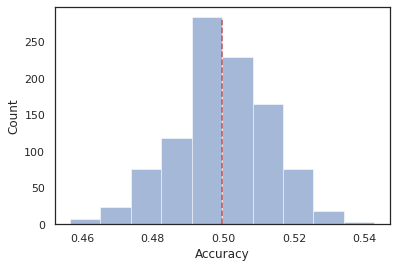

In [128]:
plt.hist(list_acc, alpha=0.5, );
plt.vlines(np.mean(list_acc), ymin=0, ymax=280, 
           color='r', linestyles='dashed');
plt.savefig('images/baseline_hist.png');
plt.xlabel('Accuracy');
plt.ylabel('Count');

# SciBERT

Code adapted from [here](here)

In [65]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading file https://hug

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

storing https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/de14937a851e8180a2bc5660c0041d385f8a0c62b1b2ccafa46df31043a2390c.74830bb01a0ffcdeaed8be9916312726d0c4cd364ac6fc15b375f789eaff4cbb
creating metadata file for /root/.cache/huggingface/transformers/de14937a851e8180a2bc5660c0041d385f8a0c62b1b2ccafa46df31043a2390c.74830bb01a0ffcdeaed8be9916312726d0c4cd364ac6fc15b375f789eaff4cbb
loading weights file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/de14937a851e8180a2bc5660c0041d385f8a0c62b1b2ccafa46df31043a2390c.74830bb01a0ffcdeaed8be9916312726d0c4cd364ac6fc15b375f789eaff4cbb
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decode

# BioBERT